In [1]:
from IPython.display import Image

## **Exercise 7.3**

#### R code + 실행결과

In [2]:
###Exercise 7.3

library(ggplot2)
library(tidyverse)
library(ggpubr)

set.seed(750481)

# data
bluecrab =
  as.matrix(read.table(url("http://www2.stat.duke.edu/~pdh10/FCBS/Exercise
s/bluecrab.dat")))
orangecrab =
  as.matrix(read.table(url("http://www2.stat.duke.edu/~pdh10/FCBS/Exercise
s/orangecrab.dat")))


## (a)
## blue crab

n = nrow(bluecrab)
ybar = colMeans(bluecrab)
Mu0 = c(ybar)
Sigma = S0 = Lambda0 = cov(bluecrab)
nu0=4

# Gibbs Sampler
inv=solve
S = 10000
MU = matrix(NA, nrow=S, ncol=2)
SIGMA = matrix(NA, nrow = S, ncol = 4)

for(s in 1:S){
  # update MU
  Lambdan = inv(inv(Lambda0) + n*inv(Sigma))
  Mun = Lambdan %*% (inv(Lambda0) %*% Mu0 + n*inv(Sigma) %*% ybar)
  Mu = MASS::mvrnorm(n=1, Mun, Lambdan)
  
  # update Sigma
  Sn = inv(S0 + (t(bluecrab) - c(Mu)) %*% t(t(bluecrab) - c(Mu)))
  Sigma = inv(rWishart(1, nu0+n, (Sn))[,,1])
  
  MU[s,] = Mu
  SIGMA[s,] = c(Sigma)
}

## Orange crab

n = nrow(orangecrab)
ybar = colMeans(orangecrab)
Mu0 = c(ybar)
Sigma = cov(orangecrab)
S0 = Lambda0 = Sigma
nu0=4

# Gibbs Sampler
inv=solve
S = 10000
MU1 = matrix(NA, nrow=S, ncol=2)
SIGMA1 = matrix(NA, nrow = S, ncol = 4)

for(s in 1:S){
  # update MU
  Lambdan = inv(inv(Lambda0) + n*inv(Sigma))
  Mun = Lambdan %*% (inv(Lambda0) %*% Mu0 + n*inv(Sigma) %*% ybar)
  Mu = MASS::mvrnorm(n=1, Mun, Lambdan)
  
  # update Sigma
  Sn = inv(S0 + (t(orangecrab) - c(Mu)) %*% t(t(orangecrab) - c(Mu)))
  Sigma = inv(rWishart(1, nu0+n, (Sn))[,,1])
  
  MU1[s,] = Mu
  SIGMA1[s,] = c(Sigma)
}


#blue crabs' theta -> MU / orange crabs' theta ->MU1


####(b)

disp = tail(1:S, S/2)

title1 = "Posterior draws of bluecrab size"
p1 = data.frame(btheta1 = MU[disp,1], btheta2 = MU[disp,2]) %>%
  ggplot(aes(x=btheta1, y=btheta2)) + geom_point(size = 0.5, color = "steelblue")+
  geom_abline(slope=1, intercept= 0)+
  coord_fixed(ratio=1)+
  labs(title=title1)

title2 = "Posterior draws of orangecrab size"
p2 = data.frame(otheta1 = MU1[disp,1], otheta2 = MU1[disp, 2]) %>%
  ggplot(aes(x=otheta1, y=otheta2))+ geom_point(size = 0.5, color = "steelblue")+
  geom_abline(slope =1, intercept = 0)+
  coord_fixed(ratio=1)+
  labs(title = title2)
ggarrange(p1, p2)

title3 = "Posterior draws of theta1 difference"
theta1_diff = MU[disp, 1] - MU1[disp, 1]
p3 = data.frame(theta1_diff = theta1_diff) %>%
  ggplot(aes(x=theta1_diff))+
  geom_histogram(color = "white", fill = "steelblue", bins = 30)+
  geom_vline(xintercept = 0)+
  labs(title=title3)

title4 = "Posterior draws of theta2 difference"
theta2_diff = MU[disp, 2] - MU1[disp, 2]
p4 = data.frame(theta2_diff = theta2_diff) %>%
  ggplot(aes(x=theta2_diff))+
  geom_histogram(color = "white", fill = "steelblue", bins = 30)+
  geom_vline(xintercept = 0)+
  labs(title=title4)

ggarrange(p3, p4)


#### (c)

bcorr = apply(SIGMA, MARGIN = 1, FUN = function(SIGMA){
  SIGMA[2] / sqrt(SIGMA[1]*SIGMA[4])
})
ocorr =apply(SIGMA1, MARGIN = 1, FUN = function(SIGMA){
  SIGMA[2] / sqrt(SIGMA[1]*SIGMA[4])
})
p5 = data.frame(crab = c(rep('blue', length(bcorr)/2), rep('orange',
                                                           length(ocorr)/2)),
                corr = c(bcorr[disp], ocorr[disp])) %>%
  ggplot(aes(x = corr, fill = crab))+
  geom_density(alpha = 0.5)+
  scale_fill_manual(values = c('blue', 'orange'))

ggarrange(p5)

mean(bcorr<ocorr)


SyntaxError: invalid syntax (<ipython-input-2-7c5330f1b10f>, line 10)

## **Gibbs Sampling**

In [4]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Ellipse
import matplotlib.transforms as transforms

def plot_gaussian_from_points(x, y, ax, n_std=3.0, facecolor='none', **kwargs):
    """
    Create a plot of the covariance confidence ellipse of *x* and *y*.
    Parameters
    ----------
    x, y : array-like, shape (n, )
        Input data.
    ax : matplotlib.axes.Axes
        The axes object to draw the ellipse into.
    n_std : float
        The number of standard deviations to determine the ellipse's radiuses.
    Returns
    -------
    matplotlib.patches.Ellipse
    Other parameters
    ----------------
    kwargs : `~matplotlib.patches.Patch` properties
    """
    if len(x) != len(y):
        raise ValueError("x and y must be the same size")
    if len(x) < 2:
        raise ValueError("Need more data.")
    cov = np.cov(x, y)
    pearson = cov[0, 1]/np.sqrt(cov[0, 0] * cov[1, 1])
    # Using a special case to obtain the eigenvalues of this
    # two-dimensionl dataset.
    ell_radius_x = np.sqrt(1 + pearson)
    ell_radius_y = np.sqrt(1 - pearson)
    ellipse = Ellipse((0, 0),
        width=ell_radius_x * 2,
        height=ell_radius_y * 2,
        facecolor=facecolor,
        **kwargs)

    # Calculating the stdandard deviation of x from
    # the squareroot of the variance and multiplying
    # with the given number of standard deviations.
    scale_x = np.sqrt(cov[0, 0]) * n_std
    mean_x = np.mean(x)

    # calculating the stdandard deviation of y ...
    scale_y = np.sqrt(cov[1, 1]) * n_std
    mean_y = np.mean(y)

    transf = transforms.Affine2D() \
        .rotate_deg(45) \
        .scale(scale_x, scale_y) \
        .translate(mean_x, mean_y)

    ellipse.set_transform(transf + ax.transData)
    return ax.add_patch(ellipse)

def plot_gaussian_from_parameters(mean, cov, ax, n_std=3.0, facecolor='none', **kwargs):
    """
    Create a plot of the covariance confidence ellipse of *x* and *y*.
    Parameters
    ----------
	mean : array-like, shape (2, )
    	Mean vector
    cov : array-like, shape (2,2)
    	Covariance matrix
    ax : matplotlib.axes.Axes
        The axes object to draw the ellipse into.
    n_std : float
        The number of standard deviations to determine the ellipse's radiuses.
    Returns
    -------
    matplotlib.patches.Ellipse
    Other parameters
    ----------------
    kwargs : `~matplotlib.patches.Patch` properties
    """
    if len(mean) != 2:
        raise ValueError("Mean vector length should be 2.")
    if (cov.shape != (2, 2)):
    	raise ValueError("Covariance should be a 2x2 matrix.")
    #checking if cov is symmetric pos semidefinite
    if(cov[0, 1] != cov[1, 0]):
        raise ValueError("Covariance should be symmetric.")
    if(cov[0, 0] < 0 or cov[0, 0]*cov[1,1] - cov[0,1]**2 < 0):
        raise ValueError("Covariance should be positive semidefinite.")

    pearson = cov[0, 1]/np.sqrt(cov[0, 0] * cov[1, 1])
    # Using a special case to obtain the eigenvalues of this
    # two-dimensionl dataset.
    ell_radius_x = np.sqrt(1 + pearson)
    ell_radius_y = np.sqrt(1 - pearson)
    ellipse = Ellipse((0, 0),
        width=ell_radius_x * 2,
        height=ell_radius_y * 2,
        facecolor=facecolor,
        **kwargs)

    # Calculating the stdandard deviation of x from
    # the squareroot of the variance and multiplying
    # with the given number of standard deviations.
    scale_x = np.sqrt(cov[0, 0]) * n_std
    mean_x = mean[0]

    # calculating the stdandard deviation of y ...
    scale_y = np.sqrt(cov[1, 1]) * n_std
    mean_y = mean[1]

    transf = transforms.Affine2D() \
        .rotate_deg(45) \
        .scale(scale_x, scale_y) \
        .translate(mean_x, mean_y)

    ellipse.set_transform(transf + ax.transData)
    return ax.add_patch(ellipse)


# from random import random

# x = np.array([random()*5 for i in range(500)])
# y = np.array([random()*5 for i in range(500)])
# fig = plt.figure()
# ax = fig.add_axes([0,0,1,1])
# ax.scatter(x, y)
# print(plot_gaussian_from_points(x, y, ax, n_std=1, edgecolor='red'))
# #print(plot_gaussian_from_parameters(np.array([2.5, 2.5]), np.cov(x, y), ax, n_std=1, edgecolor='red'))
# plt.show()

### Gibbs Sampling Mechanism (.gif 생성)

In [5]:
import numpy as np
import matplotlib.pyplot as plt

!pip install -U gif
!pip install "gif[matplotlib]"
import gif
from IPython.display import Image
from random import random

  Created wheel for gif: filename=gif-3.0.0-py3-none-any.whl size=4817 sha256=ac9ad26ec82e7a3619c433714e2ac798670e2cfcc17e0ba386a3f1c7746cccf8
  Stored in directory: c:\users\goran\appdata\local\pip\cache\wheels\21\63\09\b1e3c512d244da0a7c1d9565f09592612d04b79ccbb95146ae
Successfully built gif


In [6]:
def conditional_sampler(sampling_index, current_x, mean, cov):
    conditioned_index = 1 - sampling_index 
    a = cov[sampling_index, sampling_index] # Sigma00
    b = cov[sampling_index, conditioned_index]  # Sigma01
    c = cov[conditioned_index, conditioned_index]  # Sigma11
    
    mu = mean[sampling_index]+(b*current_x[conditioned_index]-mean[conditioned_index])/c
    sigma = np.sqrt(a-(b**2)/c)
    new_x = np.copy(current_x)
    new_x[sampling_index] = np.random.randn()*sigma + mu
    return new_x

In [7]:
def gibbs_sampler(initial_point, num_samples, mean, cov, create_gif=True):
    """
    [input 형태]z
    initial_point = [x_0, x_1] = [-9.0, -9.0]
    num_samples = 100
    mean = np.array([0, 0])
    cov = np.array([[10, 3], 
                    [3, 5]])
    """
    frames = []  # for GIF
    
    point = np.array(initial_point)
    samples = np.empty([num_samples+1, 2])  # sampled points
    samples[0] = point
    tmp_points = np.empty([num_samples, 2]) # inbetween points (중간저장소)

    for i in range(num_samples):
        # 요 for loop이 gibbs sampler 핵심
        # point = [x_0, x_1]
        
        # Sample from p(x_0|x_1)
        point = conditional_sampler(0, point, mean, cov)
        tmp_points[i] = point
        if(create_gif):
            frames.append(plot_samples(samples, i+1, tmp_points, i+1, title="Num Samples: " + str(i)))
            
        # Sample from p(x_1|x_0)
        point = conditional_sampler(1, point, mean, cov)
        samples[i+1] = point
        if(create_gif):
            frames.append(plot_samples(samples, i+2, tmp_points, i+1, title="Num Samples: " + str(i+1)))
            
    if(create_gif):
        return samples, tmp_points, frames
    else:
        return samples, tmp_points

In [8]:
@gif.frame
def plot_samples(samples, num_samples, tmp_points, num_tmp, title="Gibbs Sampling", xlims=(-11, 11), ylims=(-11, 11)):
    fig = plt.figure(figsize=(10, 8))
    ax = fig.gca()
    
    # Plot the true distribution
    plot_gaussian_from_parameters(mean, cov, ax, n_std=2, edgecolor='g', alpha=0.5, label="True Distribution")
    
    # Plot sampled points
    ax.scatter(samples[:num_samples, 0], samples[:num_samples, 1], c='b', s=10, label="Sampled Points")
    ax.scatter(samples[0, 0], samples[0, 1], marker='*', c='g', s=60, label="Initial Point")
    
    # Plot samples from conditional distribution
    ax.scatter(tmp_points[:num_tmp, 0], tmp_points[:num_tmp, 1], c='r', alpha=0.4, s=5, label="Temporary Points")
    
    # Keeping the axes scales same for good GIFS
    ax.set_xlim(xlims)
    ax.set_ylim(ylims)
    
    # Plot lines
    if(num_tmp > 0):
        ax.plot([samples[num_samples-1, 0], tmp_points[num_tmp-1, 0]], 
                [samples[num_samples-1, 1], tmp_points[num_tmp-1, 1]], c='k', alpha=0.25)
        # Plot estimated Gaussian, ignoring the starting point
        if(num_samples > 2):
            plot_gaussian_from_points(samples[1:num_samples, 0], samples[1:num_samples, 1], 
                                      ax, n_std=2, edgecolor='b', alpha=0.5, label="Estimated Distribution")
    
    ax.legend(loc='upper left')
    ax.set_title(title)

### Execution

In [9]:
mean = np.array([0, 0])
cov = np.array([[10, 3], 
                [3, 5]])

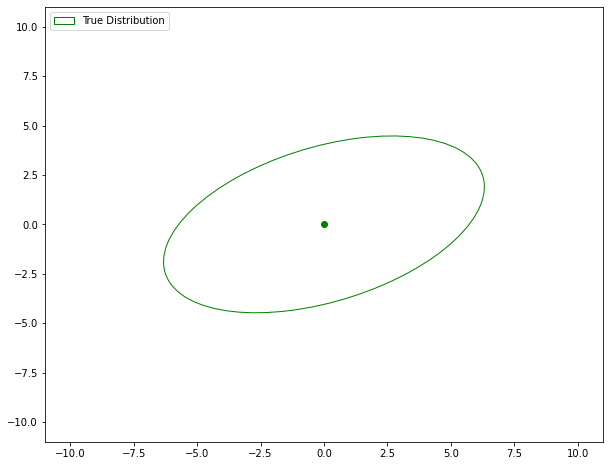

In [10]:
# Plot true distribution
fig = plt.figure(figsize=(10, 8))
ax = fig.gca()
plot_gaussian_from_parameters(mean, cov, ax, n_std=2, edgecolor='g', label="True Distribution")
ax.scatter(mean[0], mean[1], c='g')
ax.set_xlim((-11, 11))
ax.set_ylim((-11, 11))
ax.legend(loc='upper left')
plt.show()

## NA imputation using Gibbs Sample

In [ ]:
import pandas as pd
import numpy as np
import scipy.stats as stats

import missingno as msno
import matplotlib.pyplot as plt
import seaborn as sns

**dataset : pima indian diabetes dataset**  
나름 유명해서 캐글, 미국 대학 coursework 사이트에서 여러 버전 찾을 수 있음 (full, missing, etc.)

In [22]:
diabetes = pd.read_csv('./diabetes.csv')
diabetes.head()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1
3,1,89,66,23,94,28.1,0.167,21,0
4,0,137,40,35,168,43.1,2.288,33,1


In [23]:
diabetes.isna().sum()

Pregnancies                 0
Glucose                     0
BloodPressure               0
SkinThickness               0
Insulin                     0
BMI                         0
DiabetesPedigreeFunction    0
Age                         0
Outcome                     0
dtype: int64

In [24]:
diabetes.describe()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
count,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000
mean,3.845052,120.894531,69.105469,20.536458,79.799479,31.992578,0.471876,33.240885,0.348958
std,3.369578,31.972618,19.355807,15.952218,115.244002,7.884160,0.331329,11.760232,0.476951
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.078000,21.000000,0.000000
25%,1.000000,99.000000,62.000000,0.000000,0.000000,27.300000,0.243750,24.000000,0.000000
50%,3.000000,117.000000,72.000000,23.000000,30.500000,32.000000,0.372500,29.000000,0.000000
75%,6.000000,140.250000,80.000000,32.000000,127.250000,36.600000,0.626250,41.000000,1.000000
max,17.000000,199.000000,122.000000,99.000000,846.000000,67.100000,2.420000,81.000000,1.000000


In [25]:
# Mark invalid zero values as NaN (null)
temp_cols = ['Glucose', 'BloodPressure', 'SkinThickness', 'Insulin', 'BMI']  
diabetes[temp_cols] = diabetes[temp_cols].replace(0, np.nan)
print(diabetes.isnull().sum())

Pregnancies                   0
Glucose                       5
BloodPressure                35
SkinThickness               227
Insulin                     374
BMI                          11
DiabetesPedigreeFunction      0
Age                           0
Outcome                       0
dtype: int64


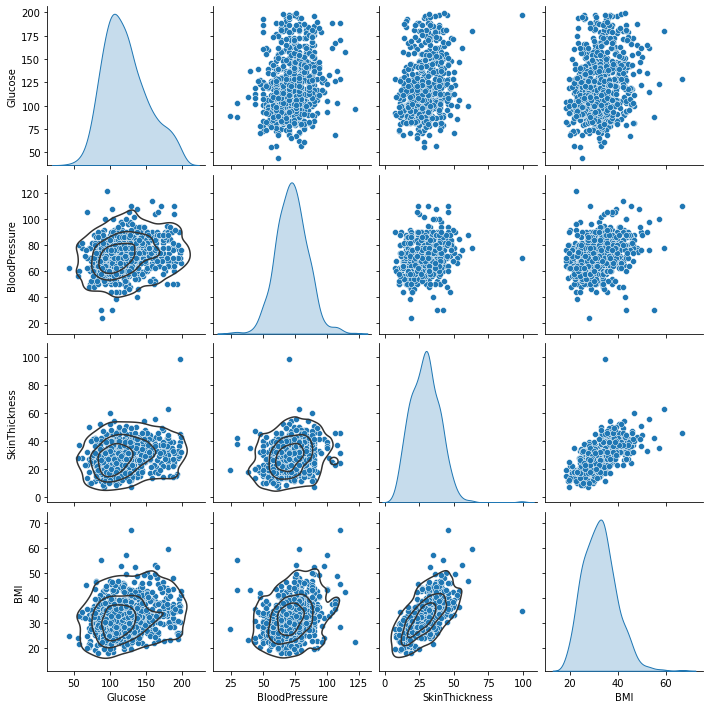

In [28]:
data = diabetes[['Glucose', 'BloodPressure', 'SkinThickness', 'BMI']]

g = sns.pairplot(data, diag_kind="kde")
g.map_lower(sns.kdeplot, levels=4, color=".2")

### Sampling Scheme 

In [30]:
n = data.shape[0]       # data 수
p = data.shape[1]       # column 수

S = 100                 # number of iteration (몇 번 update 할건지)

# 자주 쓰는 함수
inv = np.linalg.inv     # 역행렬 구하기
t = np.transpose        # transpose

# priors
## prior for mu ~ N(  ,   )
# mean vector mu_0
mu0 = data.mean().to_numpy()    # column mean

# covariance matrix Lambda_0 : 공분산 행렬 만들기
sd0 = mu0 / 2                   # 왜 이렇게 initialize하는지 모르겠지만 암튼 prior란 원래 나름의 믿음에 따라 주는거니까..
# 아마 actual dataset의 dispersion을 고려하거나 해서 그런게 아닐까..?
L0 = np.ones((p,p))*0.1         # Lambda0 in prior    
di = np.diag_indices(p)         # diagonal index indicator
L0[di] = 1                      # 일단 분산을 1로 init
L0 = L0 * np.outer(sd0, sd0)    # off-diagonal terms

## prior for Sigma ~ Ing-Wishart(   ,   )
nu0 = p + 2                     # first param
S0 = (n-p-1)*L0

# misc
Sigma = S0                      # mu의 full conditional posterior를 초기화하는데 필요함
fill_data = data.copy()         # imputate할 dataset copy 만들기

O = data.isna().to_numpy()*1    # indicator variable (결측치 있으면 1, 결측치 없으면 0)

# Naive Imputation
for col in fill_data.columns:
    # 일단 mean imputation
    # 아마 계산 시 nan 있어서 생기는 error를 방지하기 위해서 나이브하게 뭐라도 채워놓고 simulation을 돌린것같음.
    fill_data[col].fillna(fill_data[col].mean(), inplace=True)

In [34]:
for s in range(S):
    # update mu
    ybar = fill_data.mean().to_numpy()
    Ln = inv(inv(L0)+(inv(Sigma))*n)        # Lambda_n
    mun = np.matmul(Ln,
                    (np.matmul(inv(L0),mu0) + n*np.matmul(inv(Sigma),ybar)))      # mu_n
    ## sample mu from full conditional probability given Sigma & y ##
    Mu = stats.multivariate_normal.rvs(mun,Ln,1)      

    # update Sigma
    S_mu = np.matmul(t(fill_data-Mu).to_numpy(), (fill_data-Mu).to_numpy())
    Sn = S0 + S_mu
    ## sample Sigma from full conditional probability given mu & y ##
    Sigma = stats.invwishart.rvs(nu0+n, inv(Sn),1)

    # update missing data
    for i in range(n):

        # row별로 돌아가면서 1x4 array에 대해서 imputation
        # [T, F, F, T] 등의 형태로 indexing
        a = O[i,]==0        # i번째 row에 결측치 없는 위치
        b = O[i,]==1        # i번째 row에 결측치 있는 위치

        if sum(b)!=0:      
            iSa = inv(Sigma[np.outer(a,a)].reshape(sum(a),sum(a)))
            beta_j = np.matmul(Sigma[np.outer(b,a)].reshape(sum(b),sum(a)), iSa)

            # Covariance Matrix for MVN distribution
            Sigma_j = Sigma[np.outer(b,b)].reshape(sum(b),sum(b)) - np.linalg.multi_dot([Sigma[np.outer(b,a)].reshape(sum(b),sum(a)), iSa, Sigma[np.outer(a,b)].reshape(sum(a),sum(b))])
            # Mean Vector for MVN distribution
            mu_j = Mu[b] + np.matmul(beta_j, t(fill_data.iloc[i, a])-Mu[a])

            fill_data.iloc[i,b] = stats.multivariate_normal.rvs(mu_j, Sigma_j, 1)

    if s%10==0:
        print(s,"/",S)

0 / 100
10 / 100
20 / 100
30 / 100
40 / 100
50 / 100
60 / 100
70 / 100
80 / 100
90 / 100


In [35]:
# 원래 결측치 있던 data
data

,Glucose,BloodPressure,SkinThickness,BMI
0,148.0,72.0,35.0,33.6
1,85.0,66.0,29.0,26.6
2,183.0,64.0,NaN,23.3
3,89.0,66.0,23.0,28.1
4,137.0,40.0,35.0,43.1
...,...,...,...,...
763,101.0,76.0,48.0,32.9
764,122.0,70.0,27.0,36.8
765,121.0,72.0,23.0,26.2
766,126.0,60.0,NaN,30.1


In [36]:
# Gibbs Sampler로 결측치를 채운 data
fill_data

,Glucose,BloodPressure,SkinThickness,BMI
0,148.0,72.0,35.000000,33.6
1,85.0,66.0,29.000000,26.6
2,183.0,64.0,-8.419806,23.3
3,89.0,66.0,23.000000,28.1
4,137.0,40.0,35.000000,43.1
...,...,...,...,...
763,101.0,76.0,48.000000,32.9
764,122.0,70.0,27.000000,36.8
765,121.0,72.0,23.000000,26.2
766,126.0,60.0,29.316668,30.1


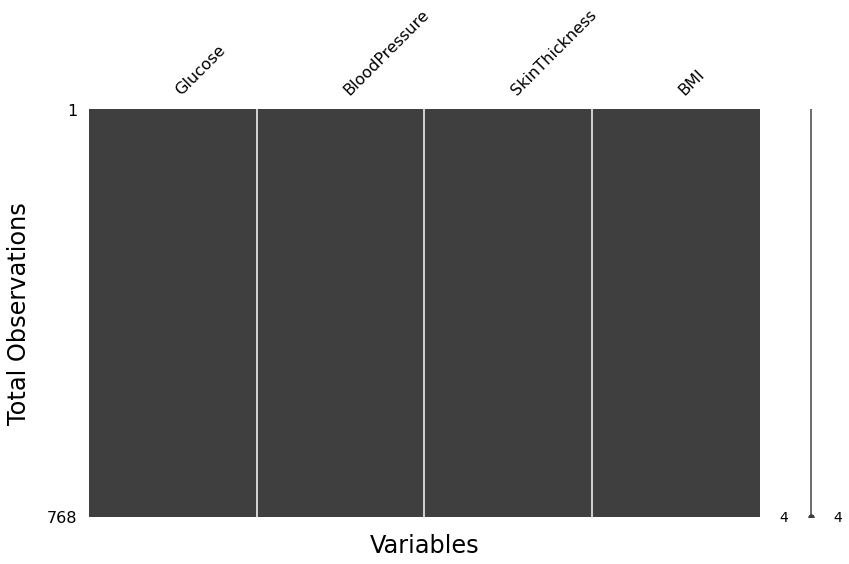

In [37]:
# Visualize the number of missing values as a matrix
fig = msno.matrix(fill_data, inline=False, figsize=(13.33,7.5))

# Add labels
plt.xlabel('Variables', size=24, labelpad=16)
plt.ylabel('Total Observations', size=24, labelpad=16)
plt.tick_params(axis='both', labelsize=16, length=8)

plt.show;

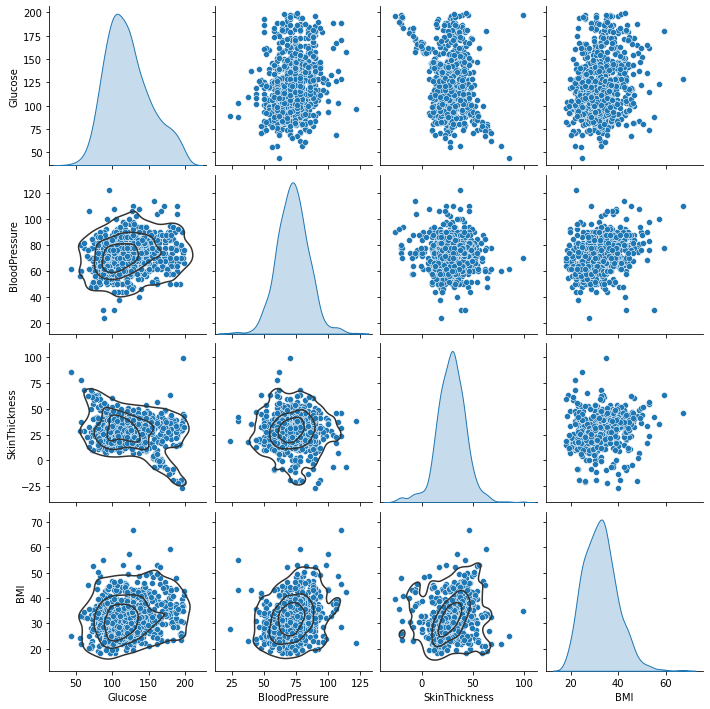

In [38]:
g_filled = sns.pairplot(fill_data, diag_kind="kde")
g_filled.map_lower(sns.kdeplot, levels=4, color=".2")